1.Apply K-Means to the dataset (choose the k clusters of your preference).
2.Calculate the Euclidean distance between each cluster’s point to their respective cluster’s centroid.
3.Represent those distances in histograms.
4.Find the outliers in the histograms.
Modified Z-score (zmod)
global outliers vs  local outliers

Atencion:
Usar pocos datos para scatter, dataset disminuido

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from numpy import genfromtxt
from scipy.stats import multivariate_normal
import pandas as pd
from datetime import datetime
import scipy.linalg as spla
from sklearn.preprocessing import StandardScaler
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'H', 'x', '+', '<', '>', '1', '2', '3', '4']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

In [2]:

df = pd.read_csv("../../datasets/LowOrbitSatelliteWithEclipses.csv", index_col='datetime')
ccantPanels     = 24
#TODO: Hacer DBScan
columns = ['vBatAverage', 
            'IInEclipse', 
            'BatteryEmergency',
            'BatterySaveMode',
            'BatteryOvertemp',
            'BatteryOvervoltage',
            'BatteryUndervoltage',
            'BatteryDischarging',
            'BatteryOvertemperature', 
            'bvrCycle',
            'ISenseRS1',
            'ISenseRS2',
            'cInEclipse',  
            'elapsedTime',
            ]

In [3]:
for i in range(ccantPanels):
    columns.append("V_MODULE_"+str(i+1)+"_SA")

In [4]:
features = ['V_MODULE_24_SA', 'vBatAverage']
print("Amount features: ", len(features), "features: ", features)

Amount features:  2 features:  ['V_MODULE_24_SA', 'vBatAverage']


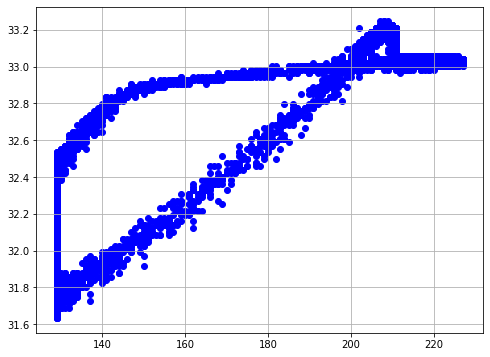

In [5]:
def simple2DPlot(df, features):
    X = df[features]

    plt.figure(figsize=(8, 6))  # Tamaño opcional del gráfico

    plt.scatter(X[features[0]], X[features[1]], marker='o', color='blue', label='Ver')
    plt.grid(True)  # Opcional: activa la cuadrícula
    plt.show()

simple2DPlot(df, features)

In [6]:
X = df[features]
n = 2
k_means = KMeans(n_clusters=n)
k_means.fit(X)
centroides = k_means.cluster_centers_
etiquetas = k_means.labels_
df["cluster"] = etiquetas


In [24]:
"""
fig, ax = plt.subplots(figsize=(14, 12))

for i in range(n):
    for index, row in X[etiquetas==i].iterrows():
        ax.scatter(row[features[0]],row[features[1]], marker=markers[i%len(markers)], color=colors[i%len(colors)])
        #ax.annotate(row["cluster"], (row[features[0]], row[features[1]]))


plt.plot(centroides[:,0],centroides[:,1],'ro', markersize=20, label='centroides')
plt.grid(True)  
plt.show()
#X[etiquetas==1]["Area (sq. mi.)"]
"""

'\nfig, ax = plt.subplots(figsize=(14, 12))\n\nfor i in range(n):\n    for index, row in X[etiquetas==i].iterrows():\n        ax.scatter(row[features[0]],row[features[1]], marker=markers[i%len(markers)], color=colors[i%len(colors)])\n        #ax.annotate(row["cluster"], (row[features[0]], row[features[1]]))\n\n\nplt.plot(centroides[:,0],centroides[:,1],\'ro\', markersize=20, label=\'centroides\')\nplt.grid(True)  \nplt.show()\n#X[etiquetas==1]["Area (sq. mi.)"]\n'

¿Que dice el metodo de codo?

K: 1 - WSS:119189595
K: 2 - WSS:2305270
K: 3 - WSS:1104242
K: 4 - WSS:592182
K: 5 - WSS:394305
K: 6 - WSS:284312
K: 7 - WSS:206582
K: 8 - WSS:161715
K: 9 - WSS:124977


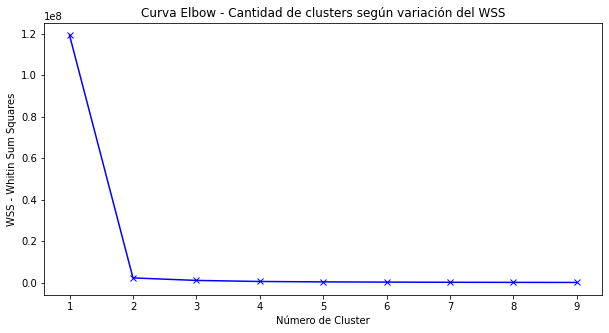

In [7]:
nClusters = range(1,10,1)
X = df[features]
# Definimos una función que para un "k" dado corre el método kmeans sobre el dataset y devuelve el modelo generado.
def correrKmeans(k, dt):
    km = KMeans(n_clusters=k, n_init=10)
    score = round(km.fit(dt).score(dt)*-1)
    print ("K: "+str(k)+" - WSS:"+str(score)) 
    return score

# Ejecutamos
scores = [correrKmeans(k, X) for k in nClusters ]
plt.figure(figsize=(10, 5))
plt.plot(nClusters,scores,'bx-')
plt.xlabel('Número de Cluster')
plt.ylabel('WSS - Whitin Sum Squares')
plt.title('Curva Elbow - Cantidad de clusters según variación del WSS')
plt.show()

Creamos una anomalia artificial

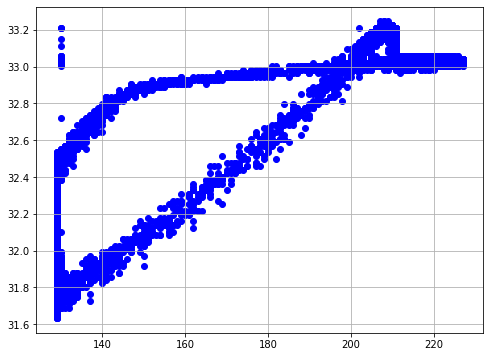

In [8]:
XWA = X.copy()
#print(XWA.index.min(), XWA.index.max())
anomaly_start_date = "2015-05-27 11:00:06+00:00 "
anomaly_end_date   = "2015-05-27 11:30:06+00:00 "

#2015-05-27 08:51:06+00:00 
#2015-06-05 23:34:06+00:00
#df['fecha'] = pd.to_datetime(df['fecha'])
XWA.loc[(XWA.index>anomaly_start_date) & (XWA.index<anomaly_end_date),"V_MODULE_24_SA"] = 130


#XWA[XWA.vBatAverage>33 ]
#pd.to_datetime(df['fecha'])
#df_filtrado = df[(df['fecha'] >= fecha_inicio) & (df['fecha'] <= fecha_fin)]

simple2DPlot(XWA, features)

In [9]:
scaler = StandardScaler()
XWA = pd.DataFrame(scaler.fit_transform(XWA[features]), columns=XWA[features].columns)


K: 1 - WSS:207640
K: 2 - WSS:8192
K: 3 - WSS:4615
K: 4 - WSS:3299
K: 5 - WSS:2285
K: 6 - WSS:1653
K: 7 - WSS:1398
K: 8 - WSS:1204
K: 9 - WSS:1030


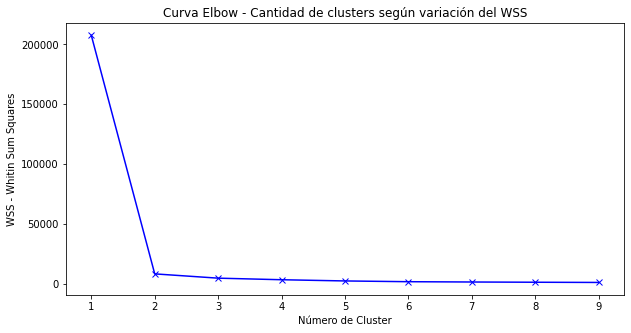

In [10]:

nClusters = range(1,10,1)
X = XWA[features]
# Definimos una función que para un "k" dado corre el método kmeans sobre el dataset y devuelve el modelo generado.
def correrKmeans(k, dt):
    km = KMeans(n_clusters=k, n_init=10)
    score = round(km.fit(dt).score(dt)*-1)
    print ("K: "+str(k)+" - WSS:"+str(score)) 
    return score

# Ejecutamos
scores = [correrKmeans(k, X) for k in nClusters ]
plt.figure(figsize=(10, 5))
plt.plot(nClusters,scores,'bx-')
plt.xlabel('Número de Cluster')
plt.ylabel('WSS - Whitin Sum Squares')
plt.title('Curva Elbow - Cantidad de clusters según variación del WSS')
plt.show()

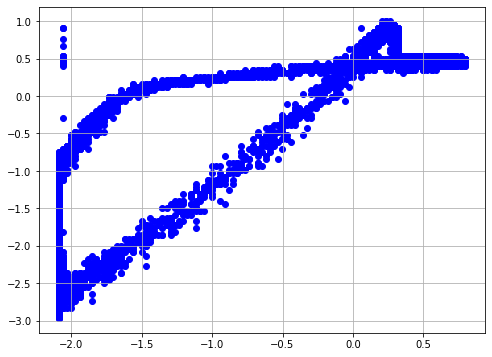

In [11]:
#Volver a hacer escalado, los puntos se consideran outlier? Seguir con esto
simple2DPlot(XWA, features)

In [12]:
print(XWA)

        V_MODULE_24_SA  vBatAverage
0             0.529455     0.443489
1             0.529455     0.397452
2             0.529455     0.443489
3             0.529455     0.443489
4             0.500036     0.443489
...                ...          ...
103815        0.294103     0.489526
103816        0.294103     0.489526
103817        0.294103     0.489526
103818        0.294103     0.489526
103819        0.294103     0.489526

[103820 rows x 2 columns]


In [13]:

X = XWA[features]
n = 2
k_means = KMeans(n_clusters=n)
k_means.fit(X)
centroides = k_means.cluster_centers_
etiquetas = k_means.labels_
X["cluster"] = etiquetas


In [14]:
irows = X[etiquetas==0]

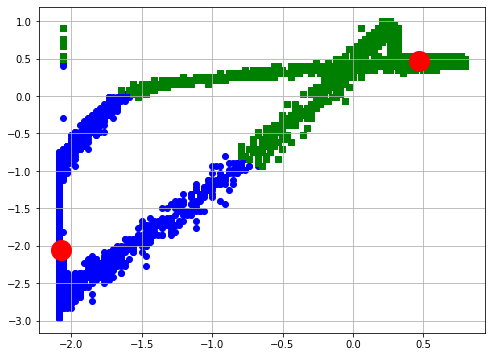

In [15]:
plt.figure(figsize=(8, 6))  # Tamaño opcional del gráfico
for i in range(n):
    x = X[X["cluster"]==i][features[0]]
    y = X[X["cluster"]==i][features[1]]
    plt.scatter(x, y, marker=markers[i%len(markers)], color=colors[i%len(colors)])

plt.plot(centroides[:,0],centroides[:,1],'ro', markersize=20, label='centroides')
plt.grid(True)  # Opcional: activa la cuadrícula
plt.show()

In [16]:


fig, ax = plt.subplots(figsize=(14, 12))

markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'H', 'x', '+', '<', '>', '1', '2', '3', '4']

j = 0
for i in range(n):
    irows = X[etiquetas==i].iterrows()
    for index, row in irows:
        ax.scatter(row[features[0]],row[features[1]], marker=markers[i%len(markers)], color=colors[i%len(colors)])
        #ax.annotate(row["cluster"], (row[features[0]], row[features[1]]))


plt.plot(centroides[:,0],centroides[:,1],'ro', markersize=20, label='centroides')
plt.grid(True)  
plt.show()
#X[etiquetas==1]["Area (sq. mi.)"]


Estandaricemos los datos

In [ ]:
#TODO: Chequear calidad

In [ ]:
scores = [correrKmeans(k, X) for k in nClusters ]
df.columns

K: 1 - WSS:223247
K: 2 - WSS:8192
K: 3 - WSS:4817
K: 4 - WSS:3468
K: 5 - WSS:2462
K: 6 - WSS:1786
K: 7 - WSS:1539
K: 8 - WSS:1352
K: 9 - WSS:1128


Index(['Unnamed: 0.1', 'Unnamed: 0', 'vBatAverage', 'IInEclipse',
       'BatteryEmergency', 'BatterySaveMode', 'BatteryOvertemp',
       'BatteryOvervoltage', 'BatteryUndervoltage', 'BatteryDischarging',
       'BatteryOvertemperature', 'bvrCycle', 'ISenseRS1', 'ISenseRS2',
       'V_MODULE_1_SA', 'V_MODULE_2_SA', 'V_MODULE_3_SA', 'V_MODULE_4_SA',
       'V_MODULE_5_SA', 'V_MODULE_6_SA', 'V_MODULE_7_SA', 'V_MODULE_8_SA',
       'V_MODULE_9_SA', 'V_MODULE_10_SA', 'V_MODULE_11_SA', 'V_MODULE_12_SA',
       'V_MODULE_13_SA', 'V_MODULE_14_SA', 'V_MODULE_15_SA', 'V_MODULE_16_SA',
       'V_MODULE_17_SA', 'V_MODULE_18_SA', 'V_MODULE_19_SA', 'V_MODULE_20_SA',
       'V_MODULE_21_SA', 'V_MODULE_22_SA', 'V_MODULE_23_SA', 'V_MODULE_24_SA',
       'dt', 'cInEclipse', 'elapsedTime', 'cluster'],
      dtype='object')

Amount features:  2 features:  ['V_MODULE_1_SA', 'V_MODULE_24_SA']


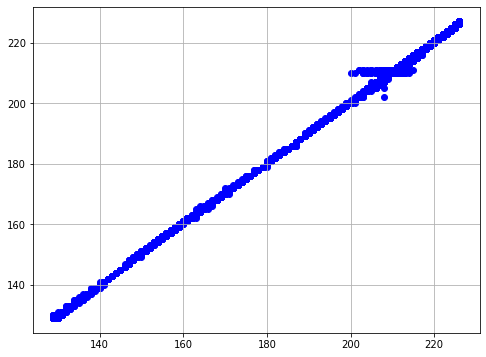

In [ ]:
features = ['V_MODULE_1_SA', 'V_MODULE_24_SA']
print("Amount features: ", len(features), "features: ", features)
simple2DPlot(df, features)


In [ ]:
%matplotlib widget